In [712]:
import tensorflow as tf
import numpy as np
import pandas as pd
#import PIL.Image
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from matplotlib import pylab as P
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

from collections import Counter


## Task 1

#### Loading out-of-distribution images

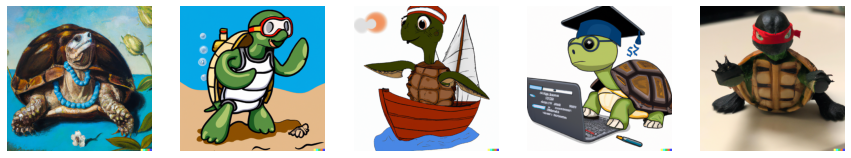

In [713]:
# Load image from file
image_filenames = ['Image1.png', 'Image2.png', 'Image3.png', 'Image4.png', 'Image5.png']

# List to store the loaded images
image_list = []

# Loop over the image filenames and load each image
for filename in image_filenames:
    image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
    
    # Add the loaded image to the list
    image_list.append(image)
    
# Create a figure with subplots
fig, axes = plt.subplots(1, len(image_list), figsize=(15, 10))

# Loop over the loaded images and plot them in the subplots
for i, image in enumerate(image_list):
    axes[i].imshow(image)
    axes[i].axis('off')

# Display the figure
plt.show()


#### Loading trained models from tensorflow

In [714]:
# VGG16
vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
vgg_model = tf.keras.models.Model([vgg.inputs], [vgg.output])

#ResNet50
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)
resnet_model = tf.keras.models.Model([resnet.inputs], [resnet.output])

#InceptionV3
inception = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=True)
inception_model = tf.keras.models.Model([inception.inputs], [inception.output])

#MobilenetV2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)
mobilenet_model = tf.keras.models.Model([mobilenet.inputs], [mobilenet.output])

#EfficientNetB5
efficientnet = tf.keras.applications.efficientnet.EfficientNetB5(weights='imagenet', include_top=True)
efficientnet_model = tf.keras.models.Model([efficientnet.inputs], [efficientnet.output])


In [715]:
## Pre-processing images to make them compatible for the ML models

def vgg_PreprocessImage(im):
    im = im.resize((224,224))
    im = np.asarray(im)
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im
def resnet_PreprocessImage(im):
    im = im.resize((224,224))
    im = np.asarray(im)
    im = tf.keras.applications.resnet50.preprocess_input(im)
    return im
def inception_PreprocessImage(im):
    im = im.resize((299,299))
    im = np.asarray(im)
    im = tf.keras.applications.inception_v3.preprocess_input(im)
    return im
def mobilenet_PreprocessImage(im):
    im = im.resize((224,224))
    im = np.asarray(im)
    im = tf.keras.applications.mobilenet_v2.preprocess_input(im)
    return im
def efficientnet_PreprocessImage(im):
    im = im.resize((456,456))
    im = np.asarray(im)
    im = tf.keras.applications.efficientnet.preprocess_input(im)
    return im



## Function to classify images by passing them through trained model
def classify(img, processing, trainedModel):
    im = processing(img)
    class_idx_str = 'class_idx_str'
    predictions = trainedModel(np.array([im]))
    prediction_class = np.argmax(predictions[0])
    #class_probability = predictions[1]
    call_model_args = {class_idx_str: prediction_class}
    img_class = prediction_class
    return img_class

In [716]:
## Downloading IMAGENET class names from tensorflow website

import requests
response = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
class_index = response.json()
class_dict = {int(k): v[1] for k, v in class_index.items()}


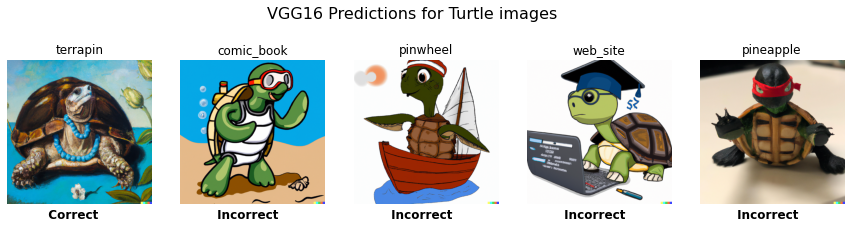

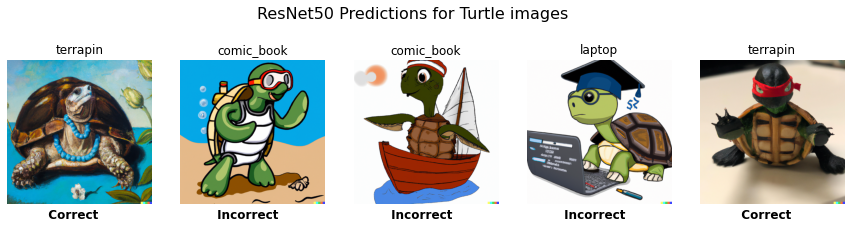

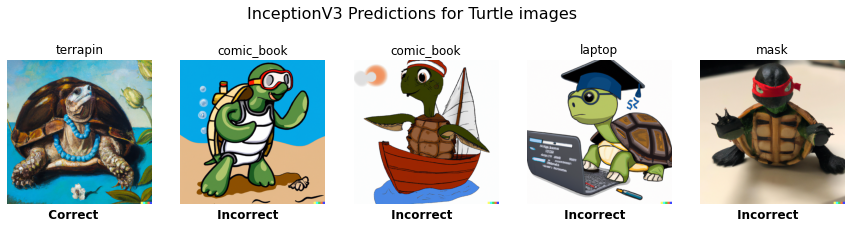

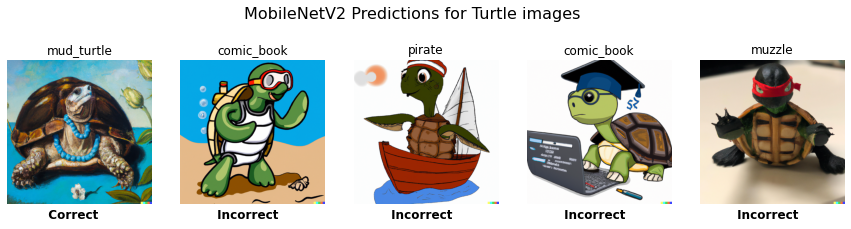

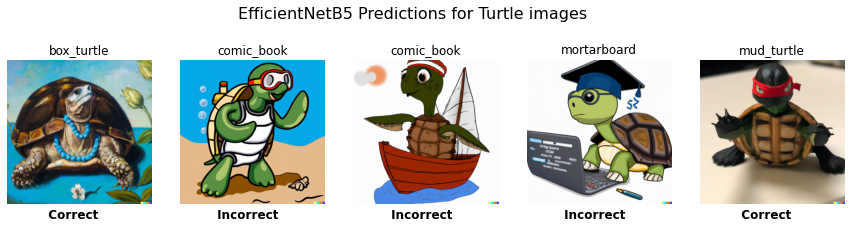

In [717]:
## Making predictions for 5 out-of-distribution images using 5 different pre-trained neural networks

model_preprocessing = [vgg_PreprocessImage,resnet_PreprocessImage,inception_PreprocessImage,mobilenet_PreprocessImage,efficientnet_PreprocessImage]
trained_models = [vgg_model, resnet_model, inception_model, mobilenet_model, efficientnet_model]
models = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2', 'EfficientNetB5']
imagenet_class_actual = [33,34,35,36,37]

predictions=[]

for i in range(len(trained_models)):
    temp=[]
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for j, image in enumerate(image_list):
        img_class = classify(image, model_preprocessing[i],trained_models[i])
        axes[j].imshow(image)
        axes[j].axis('off')
        #title = trained_models[i]
        #axes[j].set_title(img_class)
        axes[j].set_title(class_dict[img_class])

        if img_class in imagenet_class_actual:
            answer = '          Correct'
        else:
            answer = '         Incorrect'
        axes[j].text(0, -0.1,  answer, transform=axes[j].transAxes, fontsize=12, fontweight='bold')
            
        temp.append(img_class)
    predictions.append(temp)
    fig.suptitle(models[i]+' Predictions for Turtle images',  y=.85, fontsize=16)
    plt.show()
    print('\n \n \n')

# Task 2

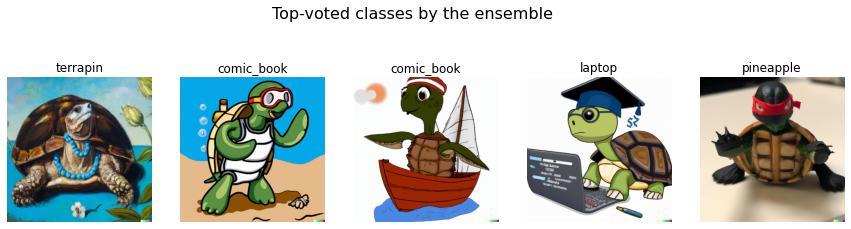

In [718]:
# Using a combination of individual pre-trained models as an Ensemble to predict image class by majority-voting approach

predictions_new  = list(map(list, zip(*predictions)))

final_prediction=[]
for pred in predictions_new:
    final_prediction.append(Counter(pred).most_common(1)[0][0])
    
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, classs in enumerate(final_prediction):
    image = image_list[i]
    top_class = class_dict[classs]
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(top_class)
fig.suptitle('Top-voted classes by the ensemble', y=.90, fontsize=16)
plt.show()

In [719]:
# Calculating class probabilites and maximum class probabilties among 5 models
class_probability = []
max_class_probability=[]
members = 5
for pred in predictions_new:
    freq= Counter(pred)
    class_probability.append(freq)
    freq_max= freq.most_common(1)[0]
    class_name = class_dict[freq_max[0]]
    prob = freq_max[1]/members
    max_class_probability.append((class_name,prob))

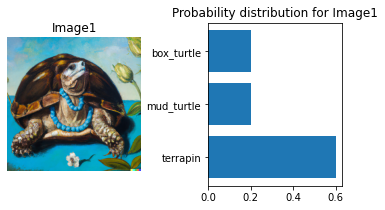

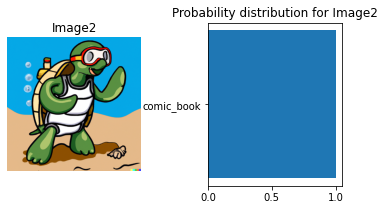

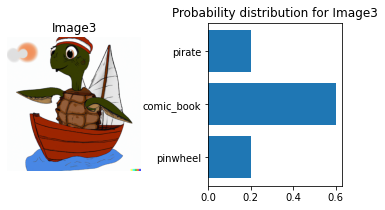

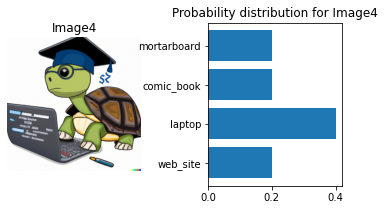

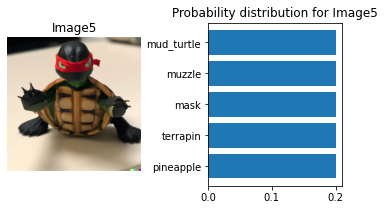

In [720]:
# Plotting class probabilties for all images

for i in range(len(image_list)):
    # Plot the image and the graph
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3))
    
    ax1.imshow(image_list[i])
    ax1.axis('off')
    ax1.set_title(f'Image{i+1}')
    
    df = pd.DataFrame(list(class_probability[i].items()), columns=['class', 'freq'])
    df['class'] = df['class'].map(class_dict)
    df['prob'] = df['freq']/5
    #print(df)
    ax2.barh(df['class'], df['prob'], label='Sin')
    ax2.set_title(f'Probability distribution for Image{i+1}')
    #ax2.set_ylabel('Probability')
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()


<BarContainer object of 5 artists>

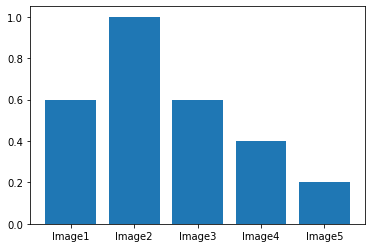

In [721]:
# Plotting the maximum probabilites for each image
df = pd.DataFrame(max_class_probability, columns=['class', 'prob'])
df['image'] = [f'Image{i}' for i in range(1,6)]

fig, ax = plt.subplots()
ax.bar(df['image'],df['prob'])

In [722]:
# Setting rank of classes on the basis their probability. Highest probability is ranked at the top.
df['rank'] = df['prob'].rank(method='dense', ascending=False)
df = df.sort_values('rank')
df

class  prob   image  rank
1  comic_book   1.0  Image2   1.0
0    terrapin   0.6  Image1   2.0
2  comic_book   0.6  Image3   2.0
3      laptop   0.4  Image4   3.0
4   pineapple   0.2  Image5   4.0

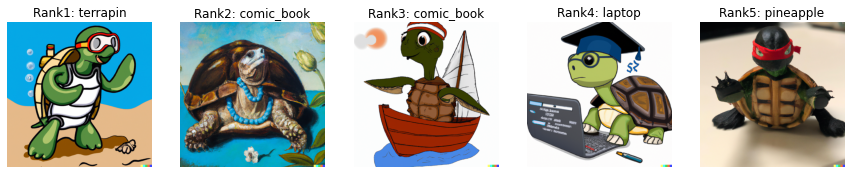

In [723]:
# Plotting images rank-wise

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i,filename in enumerate(df.image):
    image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename+'.png')
    img_class = df['class'][i]
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Rank{i+1}: {img_class}')
    

# Task 3

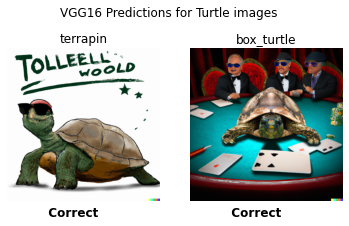

In [724]:
# Importing new images for adverserail perturbations with pre-trained ResNet50

img_list = ['Image6.png','Image7.png']

trained_models = [resnet_model]

predictions=[]

for i in range(len(trained_models)):
    temp=[]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for j,filename in enumerate(img_list):
        image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
        img_class = classify(image, model_preprocessing[i],trained_models[i])
        axes[j].imshow(image)
        axes[j].axis('off')
        axes[j].set_title(class_dict[img_class])

        if img_class in imagenet_class_actual:
            answer = '          Correct'
        else:
            answer = '         Incorrect'
        axes[j].text(0, -0.1,  answer, transform=axes[j].transAxes, fontsize=12, fontweight='bold')

        temp.append(img_class)
    predictions.append(temp)
    fig.suptitle(models[i]+' Predictions for Turtle images',  y=1.05, fontsize=12)
    plt.show()
    print('\n\n')

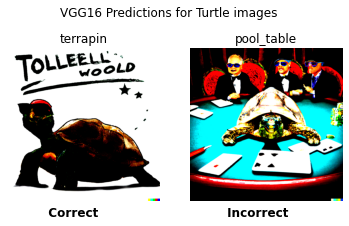

In [725]:
# Adding high contrast to the original image to manipulate model results

img_list = ['Image6.png','Image7.png']

trained_models = [resnet_model]

predictions=[]

for i in range(len(trained_models)):
    temp=[]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for j,filename in enumerate(img_list):
        image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
        contrast = ImageEnhance.Contrast(image) # Increasing contrast
        image = contrast.enhance(5)        
        img_class = classify(image, model_preprocessing[i],trained_models[i])
        axes[j].imshow(image)
        axes[j].axis('off')
        axes[j].set_title(class_dict[img_class])

        if img_class in imagenet_class_actual:
            answer = '          Correct'
        else:
            answer = '         Incorrect'
        axes[j].text(0, -0.1,  answer, transform=axes[j].transAxes, fontsize=12, fontweight='bold')

        temp.append(img_class)
    predictions.append(temp)
    fig.suptitle(models[i]+' Predictions for Turtle images',  y=1.05, fontsize=12)
    plt.show()
    print('\n\n')

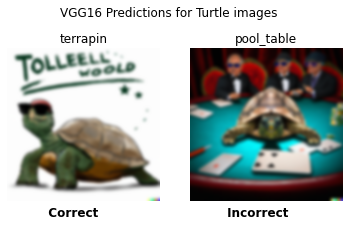

In [726]:
# Adding Blur to the original image to manipulate model results


img_list = ['Image6.png','Image7.png']

trained_models = [resnet_model]

predictions=[]

for i in range(len(trained_models)):
    temp=[]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for j,filename in enumerate(img_list):
        image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
        image = image.filter(ImageFilter.GaussianBlur(radius=10))  # Adding Blur to the image
        img_class = classify(image, model_preprocessing[i],trained_models[i])
        axes[j].imshow(image)
        axes[j].axis('off')
        axes[j].set_title(class_dict[img_class])

        if img_class in imagenet_class_actual:
            answer = '          Correct'
        else:
            answer = '         Incorrect'
        axes[j].text(0, -0.1,  answer, transform=axes[j].transAxes, fontsize=12, fontweight='bold')

        temp.append(img_class)
    predictions.append(temp)
    fig.suptitle(models[i]+' Predictions for Turtle images',  y=1.05, fontsize=12)
    plt.show()
    print('\n\n')

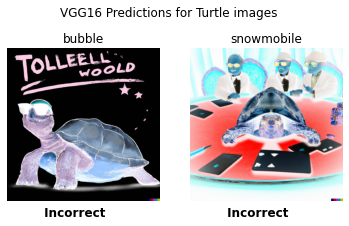

In [727]:
# Adding Colour Inversion to the original image to manipulate model results


img_list = ['Image6.png','Image7.png']

trained_models = [resnet_model]

predictions=[]

for i in range(len(trained_models)):
    temp=[]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for j,filename in enumerate(img_list):
        image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
        image = ImageOps.invert(image)  # Inverting colours    
        img_class = classify(image, model_preprocessing[i],trained_models[i])
        axes[j].imshow(image)
        axes[j].axis('off')
        axes[j].set_title(class_dict[img_class])

        if img_class in imagenet_class_actual:
            answer = '          Correct'
        else:
            answer = '         Incorrect'
        axes[j].text(0, -0.1,  answer, transform=axes[j].transAxes, fontsize=12, fontweight='bold')

        temp.append(img_class)
    predictions.append(temp)
    fig.suptitle(models[i]+' Predictions for Turtle images',  y=1.05, fontsize=12)
    plt.show()
    print('\n\n')

In [728]:
# Functions to build saliency maps using Smooth-Gradient method

import saliency.core as saliency

## The below three functions (call_model_function,ShowImage,ShowGrayscaleImage) have been taken from Lab4 of the module.

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

        
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)


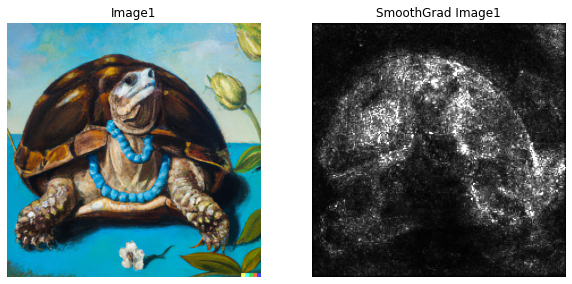

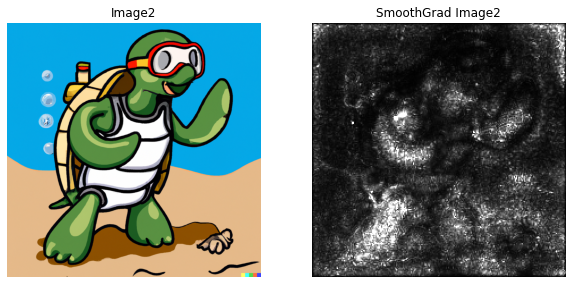

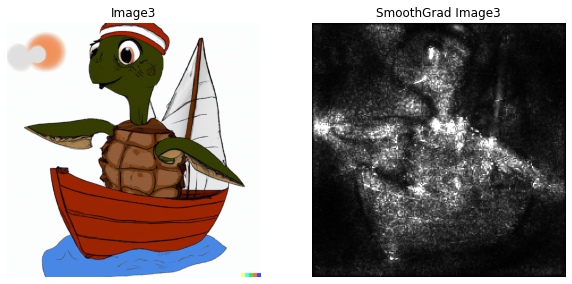

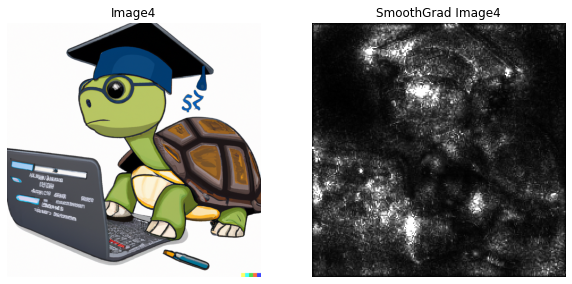

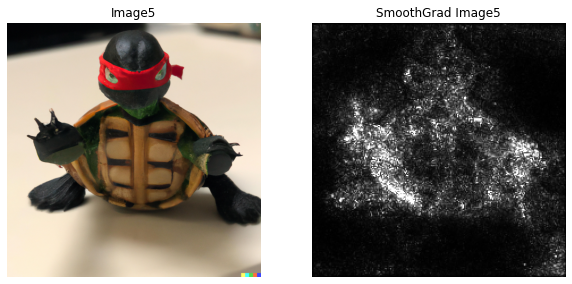

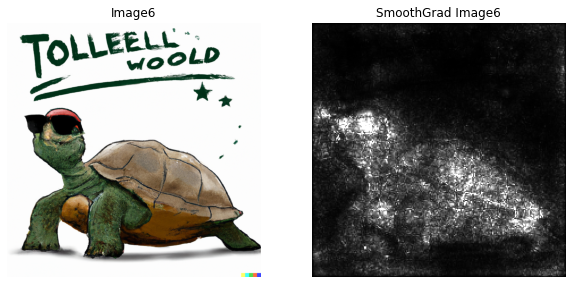

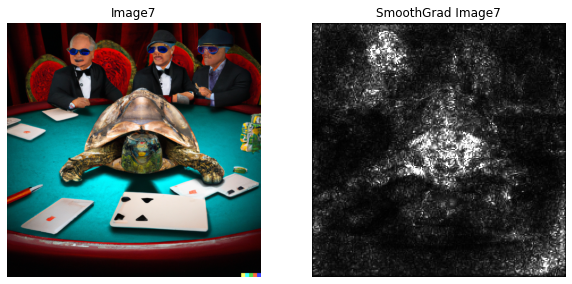

In [729]:
# Creating Saliency maps for all 7 images used in the coursework

all_images = ['Image1.png', 'Image2.png', 'Image3.png', 'Image4.png', 'Image5.png','Image6.png','Image7.png']

model = vgg_model

class_idx_str = 'class_idx_str'

#fig, axes = plt.subplots(1, 7, figsize=(15, 4))

for j,filename in enumerate(all_images):
    
    org_image = Image.open('/Users/alvis/Downloads/EthicalAI Data/'+filename)
    #ShowImage(org_image)
    image = vgg_PreprocessImage(org_image)
    #axes[j].imshow(image)
    gradient_saliency = saliency.GradientSaliency()

    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(image, call_model_function, call_model_args)

    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    # Set up matplot lib figures.
    ROWS = 1
    COLS = 2
    UPSCALE_FACTOR = 10
    P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
    i=1
    ShowImage(org_image, title=f'Image{j+1}', ax=P.subplot(ROWS, COLS, i))
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title=f'SmoothGrad Image{j+1}', ax=P.subplot(ROWS, COLS, i+1))
